In [ ]:
# # !pip install -U langgraph langsmith langchain_anthropic 
# !pip install -qU langchain-openai
# !pip install openai
# !pip install faiss-cpu
# !pip install langchain_community
# !pip install pdfplumber
# !pip install langchain_huggingface
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [17]:
from dotenv import load_dotenv
load_dotenv()

True

In [18]:
from langchain_teddynote import logging
logging.langsmith('TailorLink_QA')

LangSmith 추적을 시작합니다.
[프로젝트명]
TailorLink_QA


In [19]:
import faiss
from langchain_community.vectorstores import FAISS

def load_faiss(embeddings):
    
    current_dir = os.getcwd()
    
    # 상대 경로를 기반으로 한 절대 경로 생성
    folder_path = os.path.join(current_dir, "pdf", "faiss_db", "faiss_db")
    index_name = os.path.join(current_dir, "pdf", "faiss_db", "faiss_index")
    
    loaded_db = FAISS.load_local(
        folder_path=folder_path,
        index_name=index_name,
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
    )
    return loaded_db

In [20]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_core.documents import Document

In [21]:
import pdfplumber
import json
def LoadPDF2(file_path: str):
    docs = []
    # PDFPlumber를 사용하여 파일을 로드합니다.
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            # 페이지 크기 확인
            width, height = page.width, page.height

            # 2개의 영역(열)으로 나누기
            left_bbox = (0, 0, width / 2, height)   # 왼쪽 열
            right_bbox = (width / 2, 0, width, height)  # 오른쪽 열

            # 왼쪽 열 텍스트 추출
            left_text = page.within_bbox(left_bbox).extract_text() or ""
            
            # 오른쪽 열 텍스트 추출
            right_text = page.within_bbox(right_bbox).extract_text() or ""

            # 텍스트 병합
            page_text = left_text + "\n" + right_text

            # 문서를 Langchain 형식으로 변환하여 추가
            if page_text.strip():
                docs.append(Document(
                    page_content=page_text,
                    metadata={
                        'source': file_path,
                        'file_path': file_path,
                        'page': page.page_number,
                        'total_pages': len(pdf.pages),
                        'CreationDate': pdf.metadata.get('CreationDate', None),
                        'ModDate': pdf.metadata.get('ModDate', None)
                    }
                ))

    return docs


In [22]:
docs = LoadPDF2('../data/genesis/genesis-g90-black-24-manual-kor.pdf')


In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [24]:
def text_split(docs, chunk_size=500, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    split_documents = text_splitter.split_documents(docs)
    print(f"분할된 청크의수 : {len(split_documents)}")
    return split_documents

In [25]:
docs = text_split(docs)

분할된 청크의수 : 1482


In [26]:
from langchain_core.prompts import PromptTemplate
# 프롬프트를 생성합니다.

prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks.
    Use only the following pieces of retrieved context to answer the question. 
    Do not use any outside knowledge or assumptions. 
    If the context does not provide enough information to answer, just say that you don't know. 
    Answer in Korean and format your answer in Markdown.

    #Context: 
    {context}

    #Question:
    {question}

    #Answer (in Markdown):"""
)


In [27]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [28]:
chain = prompt | llm 

In [16]:
###############################
from evaluation.evaluation import evaluate_rag


In [18]:
# 경고 무시
import os
import warnings
warnings.filterwarnings("ignore")
# ./cache/ 경로에 다운로드 받도록 설정
os.environ["HF_HOME"] = "./cache/"

In [19]:
from langchain_huggingface import HuggingFaceEmbeddings

def get_huggingface_embedding():
    # model_name = "BAAI/bge-m3"
    model_name = "intfloat/multilingual-e5-large-instruct"
    model_kwargs = {"device": "cuda"}
    encode_kwargs = {"normalize_embeddings": True}
    hf_embeddings = HuggingFaceEmbeddings(
        model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
    )
    return hf_embeddings

hf_embeddings = get_huggingface_embedding()

In [20]:
faiss = load_faiss(hf_embeddings)

In [21]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever    

In [22]:
retriever = faiss.as_retriever(search_kwargs={"k": 10})

In [23]:
bm25 = BM25Retriever.from_documents(docs)


bm25_faiss_73 = EnsembleRetriever(
    retrievers=[bm25, retriever],  # 사용할 검색 모델의 리스트
    weights=[0.5, 0.5],  # 각 검색 모델의 결과에 적용할 가중치
    search_type="mmr",  # 검색 결과의 다양성을 증진시키는 MMR 방식을 사용
)


In [24]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# 모델 초기화
model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")

# 상위 3개의 문서 선택
compressor = CrossEncoderReranker(model=model, top_n=5)

# 문서 압축 검색기 초기화
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=bm25_faiss_73
)

# 압축된 문서 검색
compressed_docs = compression_retriever.invoke("안전벨트 에 대해서 알려줄래?")

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
chain = (
        {"context": bm25_faiss_73, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

In [26]:
chain.invoke('시동 켜는 법은?')

'```markdown\n시동을 켜기 위한 방법은 다음과 같습니다:\n\n1. 브레이크 페달을 밟은 상태에서 시동 버튼을 누릅니다.\n2. 브레이크 페달을 계속 밟고 있는 상태에서 엔진 회전이 적정 범위(1,000 RPM 이내)에 있는지 확인한 후에 변속 다이얼을 원하는 위치로 돌립니다.\n3. 전자식 파킹 브레이크를 해제한 후 브레이크 페달에서 발을 떼면서 차량이 서서히 움직이는 것을 확인하고 가속 페달을 천천히 밟아 출발합니다.\n```'

# graph 작성

In [27]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [28]:
from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o-mini")

def searchFAQ(state: State):
    print(state)
    return {"messages": [chain.invoke(state["messages"][0].content)]}

# def searchVectorDB(state: State):
#     return {"messages": [chain.invoke(state["messages"])]}
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("searchFAQ", searchFAQ)
# graph_builder.add_node("searchVectorDB", searchVectorDB)

In [29]:
graph_builder.add_edge(START, "searchFAQ")
graph_builder.add_edge("searchFAQ", END)
# graph_builder.add_edge("searchFAQ", "searchVectorDB")
# graph_builder.add_edge("searchVectorDB", END)
graph = graph_builder.compile()

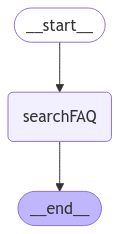

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
graph.invoke({'messages': '브레이크는 뭐야?'})

{'messages': [HumanMessage(content='브레이크는 뭐야?', additional_kwargs={}, response_metadata={}, id='4b8d132b-095e-40b2-8354-d7d5a09a3064')]}


{'messages': [HumanMessage(content='브레이크는 뭐야?', additional_kwargs={}, response_metadata={}, id='4b8d132b-095e-40b2-8354-d7d5a09a3064'),
  HumanMessage(content='브레이크는 차량의 속도를 줄이거나 정지시키기 위해 사용하는 장치입니다. 브레이크 페달을 밟으면 제동력이 발생하여 차량의 속도가 감소하게 됩니다. 이 차량에는 디스크 브레이크가 장착되어 있으며, 브레이크 패드가 마모되면 소리가 나므로 점검과 교체가 필요합니다. 추가적으로, 엔진 브레이크는 물리적인 브레이크는 아니지만 엔진의 압축 압력으로 바퀴의 회전을 억제하여 제동력을 얻는 방식입니다. \n\n브레이크 시스템의 이상이 있을 경우 브레이크 경고등이 켜지며, 이 경우 안전한 장소에 차량을 정지시키고 점검을 받아야 합니다.', additional_kwargs={}, response_metadata={}, id='45fde77c-2288-4012-8d71-f4856a72ab11')]}

In [33]:
graph.invoke({'messages': ['브레이크는 뭐야?', '시동은 어떻게 켜?']})


{'messages': [HumanMessage(content='브레이크는 뭐야?', additional_kwargs={}, response_metadata={}, id='d0cd5fdc-72b1-49f7-9b44-2f40f722d6cd'), HumanMessage(content='시동은 어떻게 켜?', additional_kwargs={}, response_metadata={}, id='76666ddb-44d8-4836-830e-37a198455d93')]}


{'messages': [HumanMessage(content='브레이크는 뭐야?', additional_kwargs={}, response_metadata={}, id='d0cd5fdc-72b1-49f7-9b44-2f40f722d6cd'),
  HumanMessage(content='시동은 어떻게 켜?', additional_kwargs={}, response_metadata={}, id='76666ddb-44d8-4836-830e-37a198455d93'),
  HumanMessage(content='브레이크는 차량의 속도를 줄이거나 정지시키기 위해 사용되는 장치입니다. 물리적인 브레이크 외에도 엔진 브레이크라는 개념이 있으며, 이는 엔진의 압축 압력으로 바퀴의 회전을 억제하여 제동력을 얻는 방법입니다. 브레이크 시스템은 안전한 주행을 위해 매우 중요하며, 적절한 점검과 유지 관리가 필요합니다.', additional_kwargs={}, response_metadata={}, id='6d274346-c2d6-4e92-b166-83e9681207bd')]}

In [34]:


import pandas as pd
from llama_index.llms.openai import OpenAI
from autorag.data.legacy.qacreation import make_single_content_qa, generate_qa_llama_index

corpus_df = pd.read_parquet('../data/test_dataset/corpus_new_test.parquet', engine='pyarrow')


[12/04/24 23:01:22] INFO     [config.py:58] >> PyTorch version 2.5.1+cu124 available.                  ]8;id=851615;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\datasets\config.py\config.py]8;;\:]8;id=669801;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\datasets\config.py#58\58]8;;\

In [39]:
from evaluation.evaluation import evaluate_rag 



In [52]:
corpus_df['generation_gt']

,retrieval_gt,qid,query,generation_gt
0,[[8bde77e8-99bc-4c6e-8684-0fb2d91666a2]],7a646d89-0061-4766-a634-1bc63c53a0f9,고속도로 주행 보조 기능은 어떻게 작동하나요?,"[고속도로 주행 보조는 주행 보조 버튼을 눌러 켜면 작동하며, 스마트 크루즈 컨트롤..."
1,[[8bde77e8-99bc-4c6e-8684-0fb2d91666a2]],c55bd7b5-2314-4102-8d0b-9354660a7245,핸즈오프 경고는 어떤 경우에 발생하나요?,[핸즈오프 경고는 일정 시간 동안 스티어링 휠을 잡지 않으면 클러스터에 경고문이 표...
2,[[53b81dbe-d185-4551-a5b9-167e67784866]],60d5a564-d231-4775-b893-607c6bdf5e05,제네시스 차량에서 자동 설정속도 조절 기능은 어떤 조건에서 작동하나요?,[자동 설정속도 조절 기능은 도로의 제한속도가 70 km/h 이상일 때 작동합니다.]
3,[[53b81dbe-d185-4551-a5b9-167e67784866]],6966da76-e355-4ca5-90be-2140929d8479,지능형 속도 제한 보조 기능에 이상이 있을 때 클러스터에 어떤 경고가 표시되나요?,[지능형 속도 제한 보조에 이상이 있으면 클러스터에 경고문이 일정 시간 표시되며 통...
4,[[79221b8b-7f94-4bc0-80cf-6d30e392f9fb]],8864b030-a96e-4533-be26-a73e77cab111,제네시스 차량의 주차 거리 경고 기능이 작동하지 않을 때 어떤 점검을 해야 하나요?,"[주차 거리 경고 기능이 작동하지 않을 경우 초음파 센서가 손상되었는지, 외부 물체..."
5,[[79221b8b-7f94-4bc0-80cf-6d30e392f9fb]],b31a4343-b9be-4c52-95dd-206a5e095a40,주차 거리 경고 기능이 제한될 수 있는 상황에는 어떤 것들이 있나요?,[주차 거리 경고 기능이 제한될 수 있는 상황으로는 초음파 센서 표면에 눈이나 물방...
6,[[28421a04-1293-4d0c-b46c-96cde8bad20a]],e39b031e-731f-472d-8f1b-02080825e7b8,제네시스 차량의 에어백은 어떤 상황에서 작동하나요?,[제네시스 차량의 에어백은 정면에서 보통 이상 강도로 충돌했을 때와 측면에서 보통 ...
7,[[28421a04-1293-4d0c-b46c-96cde8bad20a]],18e3f346-735c-460b-9f25-0dde51bebf11,제네시스 차량에서 어린이를 안전하게 보호하기 위한 권장 사항은 무엇인가요?,"[제네시스 차량에서는 어린이를 뒷좌석에 설치된 어린이 보호 좌석에 앉히고, 동승석에..."
8,[[a165ce1f-c4f4-4742-8d2a-9bca26f99b21]],e04bbb05-b346-46fb-8b4b-8f00d88a6b85,제네시스 차량의 후방 뷰 주차 가이드라인은 어떤 거리를 나타내나요?,"[후방 뷰 주차 가이드라인은 차량으로부터 0.5 m, 1 m, 2.3 m 거리를 나..."
9,[[a165ce1f-c4f4-4742-8d2a-9bca26f99b21]],552d4632-6497-4b54-926b-d2a0a6c8ef94,서라운드 뷰 모니터 자동 켜짐 기능을 설정하려면 어떤 경로를 따라야 하나요?,[서라운드 뷰 모니터 자동 켜짐 기능을 설정하려면 시동 'ON' 상태에서 인포테인먼...


In [45]:

res = graph.invoke({'messages': corpus_df['query'][0]})


{'messages': [HumanMessage(content='고속도로 주행 보조 기능은 어떻게 작동하나요?', additional_kwargs={}, response_metadata={}, id='728c41eb-8d2a-447d-8f4d-f56151c16cdd')]}


[12/04/24 23:04:15] INFO     [_client.py:1027] >> HTTP Request: POST                                ]8;id=596608;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\httpx\_client.py\_client.py]8;;\:]8;id=332943;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\httpx\_client.py#1027\1027]8;;\
                             https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"                          

In [51]:
res['messages'][1].content


'```markdown\n고속도로 주행 보조 기능은 다음의 방법으로 작동합니다:\n\n1. 작동 가능한 도로 주행 시 주행 보조 버튼을 눌러 고속도로 주행 보조를 켭니다.\n2. 스마트 크루즈 컨트롤과 차로 유지 보조가 켜진 상태로 작동 가능한 도로로 진입하면 자동으로 작동합니다.\n3. 전방 차량과의 거리와 설정 속도를 유지하며 차로 중앙을 주행하도록 도와줍니다.\n4. 고속도로 차로변경 보조 기능은 차로 변경 방향으로 방향지시등을 살짝 움직이면 안전하게 차로를 변경하도록 도와줍니다.\n\n고속도로 주행 보조는 주행을 보조하는 편의 기능이며, 운전자가 항상 조작을 해야 합니다.\n```\n'

In [59]:
evaluate_rag(corpus_df['generation_gt'][0][0], res['messages'][1].content, True, False)

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]

done in 0.12 seconds, 8.17 sentences/sec
Precision: 0.7276
Recall: 0.8619
F1 Score: 0.7891


[12/04/24 23:08:36] INFO     [SentenceTransformer.py:218] >> Load pretrained             ]8;id=319862;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=305784;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\sentence_transformers\SentenceTransformer.py#218\218]8;;\
                             SentenceTransformer:                                                                  
                             sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2                           

Batches: 100%|██████████| 1/1 [00:00<00:00, 59.68it/s]


[12/04/24 23:08:53] INFO     [_client.py:1027] >> HTTP Request: POST                                ]8;id=281601;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\httpx\_client.py\_client.py]8;;\:]8;id=344249;file://E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\httpx\_client.py#1027\1027]8;;\
                             https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"                          

{'METEOR': {'recall': 0.8695652173913043,
  'precision': 0.26666666666666666,
  'f1_score': 0.7092198581560283},
 'ROUGE-1': {'recall': 0.8695652173913043,
  'precision': 0.2631578947368421,
  'f1_score': 0.40404040404040403},
 'ROUGE-L': {'recall': 0.8260869565217391,
  'precision': 0.25,
  'f1_score': 0.3838383838383838},
 'BERTScore': {'recall': 0.8619177341461182,
  'precision': 0.7275931239128113,
  'f1_score': 0.7890797257423401},
 'Cosine Similarity': {'Cosine Similarity': 0.8653812},
 'G-EVAL': 'Similarity Score: 75\n\n이유: 두 텍스트는 모두 고속도로 주행 보조 시스템에 대한 설명을 포함하고 있습니다. 참조 텍스트는 주행 보조 버튼 작동 방식과 관련된 간단한 설명을 제공하고 있습니다. 반면, 가설 텍스트는 더 상세하게 작동 절차를 나열하고 있며, 추가적인 기능인 고속도로 차로변경 보조 기능에 대해서도 설명하고 있습니다. \n\n따라서, 두 텍스트는 기본적인 주제와 내용이 유사하지만, 가설 텍스트가 더 많은 정보를 포함하고 있어 일부 상이한 점도 존재합니다. 이로 인해 완전히 일치하지는 않지만, 꽤 높은 유사성을 가지고 있다고 판단하여 점수를 부여합니다.'}